In [144]:
import pandas as pd
import matplotlib.pyplot as plt

In [145]:
dataset_path = '../datasets/consolidated/consolidated.csv'

data = pd.read_csv(
    filepath_or_buffer=dataset_path,
)

data['date'] = pd.to_datetime(data['date']).dt.date

data

,date,positive,neutral,negative,open,high,low,volume,close
0,2013-01-21,0.224461,0.501282,0.274257,15.7,17.0,15.6,61502,16.9
1,2013-01-22,0.288634,0.496198,0.215168,16.8,17.6,16.6,60975,17.4
2,2013-01-23,0.257223,0.437274,0.305503,17.3,17.6,16.8,49439,17.9
3,2013-01-24,0.235050,0.551573,0.213377,17.5,19.2,15.6,172009,17.8
4,2013-01-25,0.231190,0.506552,0.262257,16.9,17.8,15.4,80767,18.7
...,...,...,...,...,...,...,...,...,...
2531,2019-12-27,0.226849,0.446411,0.326740,7210.8,7293.8,7128.5,718074,7261.8
2532,2019-12-28,0.169157,0.471205,0.359638,7261.9,7375.9,7256.5,610964,7196.4
2533,2019-12-29,0.197365,0.523340,0.279295,7321.6,7518.9,7303.0,611687,7199.8
2534,2019-12-30,0.170356,0.481577,0.348067,7397.5,7420.9,7244.1,606110,6967.0


In [146]:
target = 'close'

x = data.drop(columns=[target, 'date']).values
y = data[target].values

In [147]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x = scaler.fit_transform(x)
y = scaler.fit_transform(y.reshape(-1, 1))

In [148]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [149]:
import torch
import torch.nn as nn


class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, num_layers, hidden_dim, dropout):
        super().__init__()

        encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dropout=dropout
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layers,
            num_layers=num_layers
        )

        decoder_layers = nn.TransformerDecoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dropout=dropout
        )
        self.decoder = nn.TransformerDecoder(
            decoder_layers,
            num_layers=num_layers
        )

        self.fc = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_out = self.decoder(x, encoder_out)

        x = decoder_out.mean(dim=0)
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output(x)

        return x

In [150]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, yhat, y):
        return torch.sqrt(torch.mean((yhat - y)**2))

In [151]:
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, yhat, y):
        epsilon = 1e-7

        percentage_error = torch.abs(
            (y - yhat) / torch.clamp(torch.abs(y), epsilon, float('inf'))
        )

        return torch.mean(percentage_error)

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [153]:
input_dim = x_train.shape[1]
output_dim = 1
num_heads = input_dim

num_layers = 4
hidden_dim = 64
dropout = 0.1

model = TransformerModel(
    input_dim,
    output_dim,
    num_heads,
    num_layers,
    hidden_dim,
    dropout
).to(device)

In [154]:
criterion = RMSELoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [155]:
epochs = 400
total_samples = len(x_train)
batch_size = 128
loss_list = []

for epoch in range(epochs):
    for i in range(batch_size, total_samples, batch_size):
        inputs = torch.tensor(x_train[:i], dtype=torch.float32).to(device)
        outputs = torch.tensor(y_train[:i], dtype=torch.float32).to(device)

        optimizer.zero_grad()

        output = model(inputs)

        loss = criterion(output, outputs)
        loss.backward()

        optimizer.step()

    loss_list.append(loss.item())

    with torch.no_grad():
        print(f'Epoch {epoch+1}, Loss: {loss.item():.5f}')

Epoch 1, Loss: 0.21081
Epoch 2, Loss: 0.02629
Epoch 3, Loss: 0.02881
Epoch 4, Loss: 0.05057
Epoch 5, Loss: 0.02851
Epoch 6, Loss: 0.03236
Epoch 7, Loss: 0.02874
Epoch 8, Loss: 0.03567
Epoch 9, Loss: 0.02790
Epoch 10, Loss: 0.05133
Epoch 11, Loss: 0.03669
Epoch 12, Loss: 0.03174
Epoch 13, Loss: 0.02943
Epoch 14, Loss: 0.02750
Epoch 15, Loss: 0.04203
Epoch 16, Loss: 0.03545
Epoch 17, Loss: 0.02929
Epoch 18, Loss: 0.02824
Epoch 19, Loss: 0.03647
Epoch 20, Loss: 0.02623
Epoch 21, Loss: 0.02925
Epoch 22, Loss: 0.04083
Epoch 23, Loss: 0.03258
Epoch 24, Loss: 0.03240
Epoch 25, Loss: 0.02630
Epoch 26, Loss: 0.02613
Epoch 27, Loss: 0.02731
Epoch 28, Loss: 0.02612
Epoch 29, Loss: 0.02617
Epoch 30, Loss: 0.03037
Epoch 31, Loss: 0.02622
Epoch 32, Loss: 0.02923
Epoch 33, Loss: 0.04896
Epoch 34, Loss: 0.02635
Epoch 35, Loss: 0.02612
Epoch 36, Loss: 0.02635
Epoch 37, Loss: 0.02878
Epoch 38, Loss: 0.02920
Epoch 39, Loss: 0.02747
Epoch 40, Loss: 0.03740
Epoch 41, Loss: 0.03149
Epoch 42, Loss: 0.02611
E

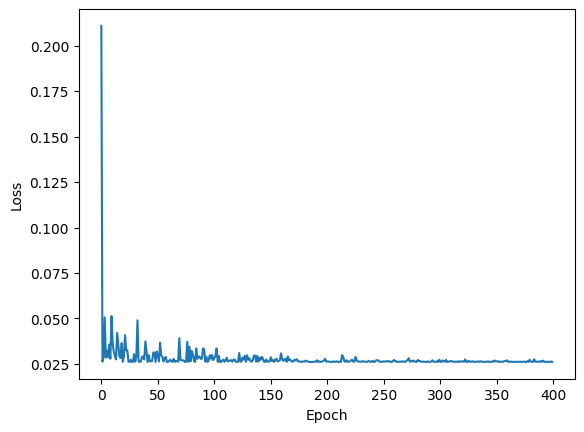

In [156]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [159]:
criterion = RMSELoss().to(device)

model.eval()

with torch.no_grad():
    inputs = torch.tensor(x_test, dtype=torch.float32).to(device)
    targets = torch.tensor(y_test, dtype=torch.float32).to(device)

    outputs = model(inputs)

    loss = criterion(outputs, targets)

    print(f'RMSE: {loss.item():.5f}')

RMSE: 0.02338


In [160]:
criterion = MAPELoss().to(device)

model.eval()

with torch.no_grad():
    inputs = torch.tensor(x_test, dtype=torch.float32).to(device)
    targets = torch.tensor(y_test, dtype=torch.float32).to(device)

    outputs = model(inputs)

    loss = criterion(outputs, targets)

    print(f'MAPE: {loss.item():.5f}')

MAPE: 0.03440
